In [56]:
using Plots
import Plots: plot!, vline!
using LinearAlgebra

In [57]:
mutable struct WienerProcess{T<:Number}
    mu::T
    sigma2::T
    timestep::T
    values::Vector{T}
    steps::Int
    times::Vector{T}

    # Constructeur pour initialiser le processus sans valeurs simulées
    function WienerProcess{T}(mu::T, sigma2::T, timestep::T, steps::Int) where T<:Number
        new{T}(mu, sigma2, timestep, Vector{T}(), steps, collect(0:timestep:steps * timestep))
    end
end

In [58]:
# Fonction pour simuler le processus de Wiener
function simulate!(wp::WienerProcess)
    sqrt_sigma2 = sqrt(wp.sigma2)
    wp.values = [0.0]
    for t in 1:wp.steps
        dt = wp.timestep
        dW = sqrt_sigma2 * sqrt(dt) * randn()
        new_value = wp.values[end] + wp.mu * dt + dW
        push!(wp.values, new_value)
    end
end

simulate! (generic function with 2 methods)

In [59]:
# Méthode pour tracer le processus de Wiener
function plot!(process::WienerProcess)
    # Tracer le processus de Wiener
    plot!(process.times, process.values, xlabel="Time", ylabel="Wiener Process", label="Wiener Process", 
    linestyle=:dash, markershape=:circle, markercolor=:blue)
    
    # Tracer la droite mu*t
    plot!(process.times, process.mu .* process.times, label="mu*t", linestyle=:dash)
end

plot! (generic function with 6 methods)

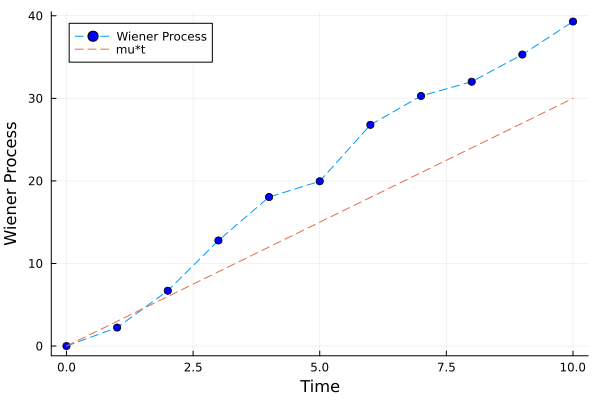

In [66]:
# Définir les paramètres du processus de Wiener
mu = 3.0
sigma2 = 5.0
timestep = 1.
steps = 10

# Créer une instance de WienerProcess
process = WienerProcess{Float64}(mu, sigma2, timestep, steps)

# Simuler le processus de Wiener
simulate!(process)

plot()
# Tracer le processus de Wiener simulé
plot!(process)

In [67]:
mutable struct WienerARD1
    underlying_process::WienerProcess{Float64}
    rho::Float64
    maintenance_times::Vector{Float64}
    k::Int
    values::Vector{Vector{Float64}}
    new_times::Vector{Vector{Float64}}

    function WienerARD1(mu::Float64, sigma2::Float64, timestep::Float64, steps::Int, rho::Float64, maintenance_times::Vector{Float64})
        underlying_process = WienerProcess{Float64}(mu, sigma2, timestep, steps)
        simulate!(underlying_process)
        
        k = length(maintenance_times)
        
        # Initialize new_times array
        new_times = Vector{Vector{Float64}}()
        start_time = 0.0
        
        # Populate new_times with intervals up to each maintenance time
        for i in 1:length(maintenance_times)
            end_time = maintenance_times[i]
            push!(new_times,collect(start_time:timestep:end_time))
            start_time = end_time
        end
        
        # Last segment from last maintenance time to the end
        push!(new_times, collect(start_time:timestep:(steps * timestep)))
        
        new(underlying_process, rho, maintenance_times, k, Vector{Vector{Float64}}(), new_times)
    end
end

In [7]:
function adjust_values!(process::WienerARD1)
    new_values = Float64[]

    last_before_maintenance = findlast(t -> t <= process.maintenance_times[1], process.underlying_process.times)
    if last_before_maintenance !== nothing
        # Concatenate the part before last_before_maintenance into new_values
        append!(new_values, process.values[1:last_before_maintenance])
    end

    for i in 1:length(process.maintenance_times) -1
        mtn_time = process.maintenance_times[i]
        next_mtn_time = process.maintenance_times[i+1]
        between_maintenances = findall(t -> t > mtn_time && t<=next_mtn_time, process.underlying_process.times)
        append!(new_values, (1 - process.rho) * process.underlying_process.values[between_maintenances[1]-1])
        display("between maintenances :")
        display(between_maintenances)
        if !isempty(between_maintenances)
            # Concatenate the part before last_before_maintenance into new_values
            append!(new_values, process.values[between_maintenances])
        end
    end
    append!(new_values, (1 - process.rho) * process.underlying_process.values[process.maintenance_times[end]+1])
    append!(new_values, process.values[process.maintenance_times[end]+2:end])
    process.values = new_values
end

adjust_values! (generic function with 1 method)

In [72]:
function simulate!(process::WienerARD1)
    
    # Créer un vecteur Y initialisé avec les valeurs de X
    Y = copy(process.underlying_process.values)
    
    # Modifier les valeurs de Y selon les règles spécifiées
    for i in 1:length(process.maintenance_times) - 1
        maintenance_time = process.maintenance_times[i]
        next_maintenance_time = process.maintenance_times[i+1]
        
        # Indices des temps entre deux instants de maintenance
        indices = findall(t -> t > maintenance_time && t <= next_maintenance_time, process.underlying_process.times)
        
        # Mettre à jour les valeurs de Y
        Y[indices] .-= process.rho .* process.underlying_process.values[indices[1] - 1]  
    end
    
    indices = findall(t -> t > process.maintenance_times[length(process.maintenance_times)], process.underlying_process.times)
    Y[indices] .-= process.rho .* process.underlying_process.values[indices[1] - 1]  
    # Mettre à jour les valeurs de Y dans la structure process
    new_values = Float64[]

    last_before_maintenance = findlast(t -> t <= process.maintenance_times[1], process.underlying_process.times)
    if last_before_maintenance !== nothing
        # Concatenate the part before last_before_maintenance into new_values
        append!(new_values, Y[1:last_before_maintenance])
    end
    for i in 1:length(process.maintenance_times) -1
        mtn_time = process.maintenance_times[i]
        next_mtn_time = process.maintenance_times[i+1]
        between_maintenances = findall(t -> t > mtn_time && t<=next_mtn_time, process.underlying_process.times)
        append!(new_values, (1 - process.rho) * process.underlying_process.values[between_maintenances[1]-1])
        # display("between maintenances :")
        # display(between_maintenances)
        if !isempty(between_maintenances)
            # Concatenate the part before last_before_maintenance into new_values
            append!(new_values, Y[between_maintenances])
        end
    end
    m = findfirst(t -> t == process.maintenance_times[end], process.underlying_process.times)
    append!(new_values, (1 - process.rho) * process.underlying_process.values[m])
    append!(new_values, Y[m+1:end])

    t1 = 1
    t2 = 0
   for i in 1:process.k+1
        t2 = length(process.new_times[i]) + t2
        push!(process.values, new_values[t1:t2])
        t1 = t2 + 1
   end
end

simulate! (generic function with 2 methods)

In [73]:
mu = 3.0
sigma2 = 5.0
timestep = 1.
steps = 10
rho = 0.3
maintenance_times = [ 3. * i for i in 1:2]

# Créer une instance de WienerProcess
processARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
simulate!(processARD1)


In [76]:
# Méthode pour tracer le processus de Wiener avec les temps de maintenance
function plot!(process::WienerARD1)
    # Tracer le processus de Wiener
    # plot(process.underlying_process.times, process.values, xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process", legend=:topright)
    plot(xlabel="Time", ylabel="WienerARD1 Process", label="WienerARD1 Process")
    for i in 1:process.k+1
        plot!(process.new_times[i], process.values[i], linestyle=:dash, markershape=:circle, markercolor=:red, color=:blue, legend=:false)
    end
    # Tracer la droite mu*t
    plot!(process.underlying_process.times, process.underlying_process.mu .* process.underlying_process.times, label="mu*t", linestyle=:dash)

    vline!(process.maintenance_times, label="Maintenance Time", color=:red)
end


plot! (generic function with 6 methods)

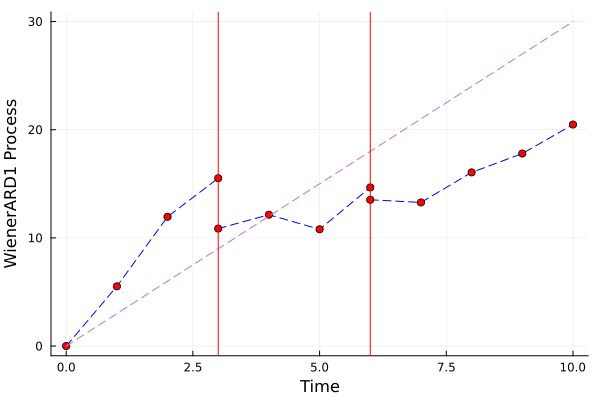

In [77]:
# Simuler le processus de Wiener avec les temps de maintenance
plot!(processARD1)
# plot!(processARD1.underlying_process)

In [78]:
function indicatrice(j::Int)
    return j > 1
end

indicatrice (generic function with 1 method)

In [79]:
# Initialize Sigma matrix
function Sigma(rho::Float64)
    n = length(processARD1.maintenance_times)
    Sigma = Matrix{Float64}(undef, n, n)

    # Populate Sigma using array comprehensions
    Sigma .= [
        i == j ? 1 + rho^2 * indicatrice(j) + (1 - rho)^2 :               # Diagonal elements
        i == j + 1 || i == j - 1 ?  # Off-diagonal elements
        -rho :                      # If adjacent
        0.0                         # Otherwise
        for i in 1:n, j in 1:n
    ]

    return Sigma
end

Sigma (generic function with 1 method)

In [80]:
Sigma(0.3)

2×2 Matrix{Float64}:
  1.49  -0.3
 -0.3    1.58

In [128]:
function u(j::Int, rho::Float64, ps::WienerARD1)
    return 1 - rho * indicatrice(j) + 1 - rho
end

u (generic function with 2 methods)

In [129]:
function v(j::Int, rho::Float64, ps::WienerARD1)

return rho * sum(diff(ps.values[j]))

end

v (generic function with 2 methods)

In [130]:
v(1, rho, processARD1)

4.654553068175759

In [131]:
function delta_y(ps::WienerARD1)
    differences = Float64[]

    # Parcourir les données
    for i in 1:ps.k + 1
        append!(differences, diff(ps.values[i]))
    end

    return differences
end

delta_y(processARD1)

10-element Vector{Float64}:
  5.5193911715991275
  6.433938336696907
  3.561847385623162
  1.2812002904705242
 -1.3484395507889033
  3.871870243884068
 -0.24718913221193617
  2.7779205191127687
  1.7435675744922428
  2.680760781439613

In [132]:
function z(ps::WienerARD1)
    # Initialiser un vecteur pour stocker les différences successives
    differences = Float64[]

    # Parcourir les données
    for i in 1:ps.k
        push!(differences, ps.values[i][end] - ps.values[i + 1][1])
    end

    return differences
end

println(z(processARD1))

[4.65455306817576, 1.1413892950697075]


In [133]:
function mu_chapeau(rho::Float64, ps::WienerARD1)
    # Calculer l'inverse de Sigma
    Sigma_inv = inv(Sigma(rho))

    V = [v(j, rho, ps) for j in 1:size(Sigma_inv)[1]] #/

    U = [u(j, rho, ps) for j in 1:length(V)] #/

    Z = z(ps) #/

    # Calculer le produit transpose(u) * Sigma_inv_v
    a = dot(U, Sigma_inv * Z)

    b = dot(U, Sigma_inv * V)

    c = sum(V) / rho

    d = dot(U, Sigma_inv * U)

    e = length(processARD1.values) - length(processARD1.maintenance_times) - 1

    return (a + b + c) / (d + e)
end

mu_chapeau (generic function with 1 method)

In [137]:
function sigma2_chapeau(rho::Float64, ps::WienerARD1)
    
    Sigma_inv = inv(Sigma(rho))

    V = [v(j, rho, ps) for j in 1:size(Sigma_inv)[1]]

    U = [u(j, rho, ps) for j in 1:length(V)]

    Z = z(processARD1)

    # Calculer le produit transpose(u) * Sigma_inv_v
    a = Z - mu_chapeau(rho, processARD1) .* U + V

    b = dot(a, Sigma_inv * a)
    
    diffs = delta_y(processARD1)

    d = sum((dy_j - mu_chapeau(rho, processARD1))^2 for dy_j in diffs)

    N = sum(length(processARD1.values[i]) for i in 1:processARD1.k + 1) - 2 * processARD1.k

    return (b + d) / N
end

sigma2_chapeau (generic function with 1 method)

In [140]:
function estimateur_rho_chapeau()

    rhos = [ 0.05 * i for i in 1:20]

    N = sum(length(processARD1.values[i]) for i in 1:processARD1.k + 1) - 2 * processARD1.k

    f = [N * log(sigma2_chapeau(rho, processARD1)) / 2 + log(det(Sigma(rho))) / 2 for rho in rhos]

    return rhos[argmin(f)]
end

estimateur_rho_chapeau (generic function with 1 method)

In [142]:
estimateur_rho_chapeau()

0.05

In [146]:
mu = 3.0
sigma2 = 5.0
timestep = 1.
steps = 100
rho = 0.7
maintenance_times = [ 10. * i for i in 1:9]
estimations = []

for i in 1:100
    # Créer une instance de WienerProcess
    processARD1 = WienerARD1(mu, sigma2, timestep, steps, rho, maintenance_times)
    simulate!(processARD1)
    push!(estimations, estimateur_rho_chapeau())
end

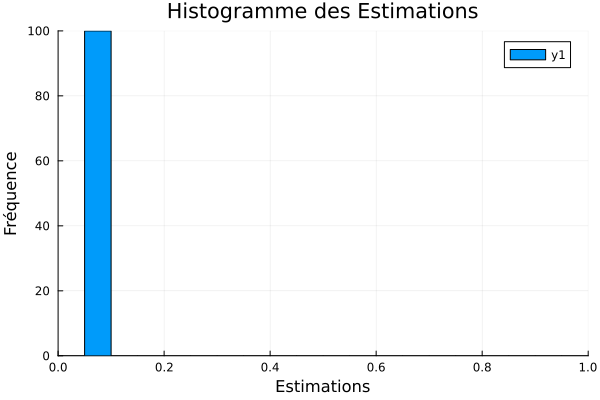

In [147]:
histogram(estimations, bins=0:0.05:1, xlabel="Estimations", ylabel="Fréquence", title="Histogramme des Estimations", xlims=(0, 1))

In [50]:
println(estimations)

Any[0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.70000000000000